<center>

# **22AIE401 - Reinforcement Learning**  
# **Lab 3**  

</center>

### Team Members:
- Guruprasath M R - AIE22015  
- Rudraksh Mohanty - AIE22046  
- Shree Prasad M - AIE22050  
- Tharun Kaarthick G K - AIE22062  

---

### Objective:
To model a real-world warehouse navigation problem as a Markov Decision Process (MDP) and solve it using Value Iteration to find the optimal path for a robot, minimizing delivery time and avoiding obstacles. 

---

### Problem Statement:
Warehouse Robot Path Optimization using Value Iteration 
In modern warehouses (like Amazon), robots move around grid-based layouts to pick and deliver 
packages. They must: 
 - Avoid shelves (obstacles) 
 - Take the shortest and safest route
 - Deliver the package to the goal location
 - Minimize collisions and redundant moves. 


---

### Common Interpretation after completing tasks:
To be filled

## Original Code

In [9]:
%pip install pymdptoolbox

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


  Current Goal Position: (1, 4)

📍 Optimal Policy Grid:
[['→' '→' '→' '→' '↓']
 ['↑' '→' '→' '→' '↑']
 ['↑' '←' '→' '→' '↑']
 ['↑' '↓' '↓' '↑' '↑']
 ['→' '→' '→' '→' '↑']]


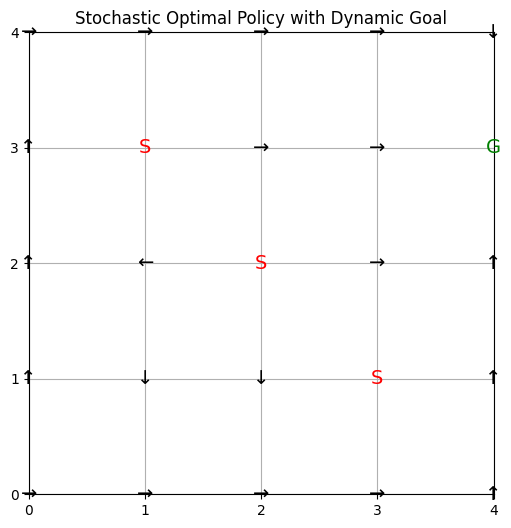

In [10]:
import numpy as np 
import mdptoolbox 
import matplotlib.pyplot as plt 
import random 

# Grid Parameters
rows, cols = 5, 5
num_states = rows * cols 
shelves = [(1, 1), (2, 2), (3, 3)] # Obstacle positions
actions = ['up', 'down', 'left', 'right'] 
num_actions = len(actions) 
movement = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)} 

# Function to map (x, y) to index
def to_index(x, y): 
    return x * cols + y 

# Function to randomly set a goal not on a shelf
def set_dynamic_goal(): 
    possible = [(i, j) for i in range(rows) for j in range(cols) if (i, j) not in shelves] 
    return random.choice(possible)

# Randomly choose a goal position
goal_state = set_dynamic_goal() 
print("  Current Goal Position:", goal_state) 

# Transition and Reward Matrices
P = [np.zeros((num_states, num_states)) for _ in range(num_actions)] 
R = np.zeros((num_states, num_actions)) 

# Build MDP with stochastic transitions (intended: 0.9, unintended: 0.1 split across others)
for action_idx, action in enumerate(actions):
    dx, dy = movement[action] 
    for x in range(rows): 
        for y in range(cols): 
            current_state = to_index(x, y)
            if (x, y) == goal_state: 
                P[action_idx][current_state, current_state] = 1
                R[current_state, action_idx] = 10
                continue
            outcomes = [] 
            
            # Intended move (90%)
            new_x, new_y = x + dx, y + dy 
            if (new_x, new_y) in shelves or not (0 <= new_x < rows and 0 <= new_y < cols): 
                new_state = current_state
                reward = -5 if (new_x, new_y) in shelves else -1
            else: 
                new_state = to_index(new_x, new_y) 
                reward = -1
            outcomes.append((new_state, 0.9, reward)) 
            
            # 10% misstep (wrong move in any of the other 3 directions)
            other_actions = [a for i, a in enumerate(actions) if i != action_idx] 
            for mis_action in other_actions: 
                mx, my = movement[mis_action] 
                new_x, new_y = x + mx, y + my 
                if (new_x, new_y) in shelves or not (0 <= new_x < rows and 0 <= new_y < cols): 
                    mis_state = current_state 
                    mis_reward = -5 if (new_x, new_y) in shelves else -1
                else: 
                    mis_state = to_index(new_x, new_y) 
                    mis_reward = -1
                outcomes.append((mis_state, 0.1 / 3, mis_reward)) 
            for s_next, prob, rew in outcomes: 
                P[action_idx][current_state, s_next] += prob 
                R[current_state, action_idx] += prob * rew # Expected reward

# Run Value Iteration
vi = mdptoolbox.mdp.ValueIteration(P, R, 0.9) 
vi.run() 

# Reshape policy to grid
policy_grid = np.array(vi.policy).reshape((rows, cols)) 
action_symbols = ['↑', '↓', '←', '→'] 
policy_symbols = np.array([[action_symbols[a] for a in row] for row in policy_grid]) 
print("\n📍 Optimal Policy Grid:") 
print(policy_symbols) 

# Plotting
plt.figure(figsize=(6, 6)) 
for x in range(rows): 
    for y in range(cols): 
        idx = to_index(x, y) 
        if (x, y) == goal_state: 
            plt.text(y, rows - x - 1, 'G', ha='center', va='center', fontsize=14, color='green') 
        elif (x, y) in shelves: 
            plt.text(y, rows - x - 1, 'S', ha='center', va='center', fontsize=14, color='red') 
        else: 
            plt.text(y, rows - x - 1, action_symbols[vi.policy[idx]], ha='center', va='center', fontsize=14) 
plt.xticks(range(cols)) 
plt.yticks(range(rows)) 
plt.grid(True) 
plt.title("Stochastic Optimal Policy with Dynamic Goal") 
plt.show()

## Task 1: One-Way Paths (Directional Constraints)

This cell demonstrates how to modify the transition matrix so that certain paths allow movement in only one direction (e.g., left-to-right only). The robot must learn policies compliant with these constraints.

**Changes with respect to the original code:**
- Added a `one_way_edges` list to specify grid edges with one-way movement.
- Modified the transition matrix so movement is only allowed in the specified direction for those edges.
- All other code remains unchanged.



📍 Optimal Policy Grid (One-Way):
[['↓' '←' '←' '←' '←']
 ['↓' '←' '↑' '↑' '↑']
 ['↑' '→' '→' '→' '↓']
 ['↑' '←' '←' '←' '↓']
 ['↑' '←' '←' '←' '←']]


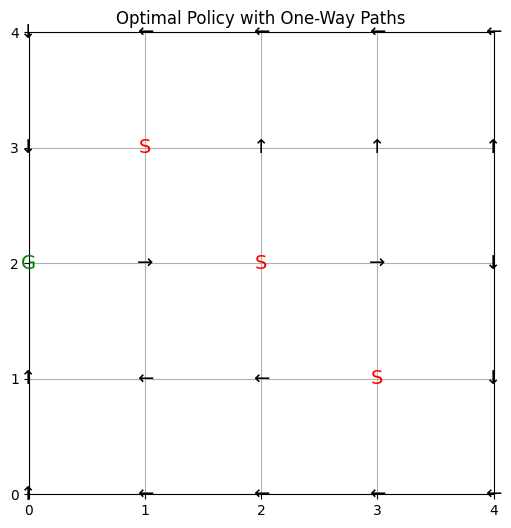

In [11]:
# Task 1: One-Way Paths (Directional Constraints)
import numpy as np
import mdptoolbox
import matplotlib.pyplot as plt
import random

rows, cols = 5, 5
num_states = rows * cols
shelves = [(1, 1), (2, 2), (3, 3)]
actions = ['up', 'down', 'left', 'right']
num_actions = len(actions)
movement = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}

def to_index(x, y):
    return x * cols + y

def set_dynamic_goal():
    possible = [(i, j) for i in range(rows) for j in range(cols) if (i, j) not in shelves]
    return random.choice(possible)
goal_state = set_dynamic_goal()

# Specify one-way edges: only allow left-to-right movement for row 2
one_way_edges = [((2, i), (2, i+1)) for i in range(cols-1)]

P = [np.zeros((num_states, num_states)) for _ in range(num_actions)]
R = np.zeros((num_states, num_actions))
for action_idx, action in enumerate(actions):
    dx, dy = movement[action]
    for x in range(rows):
        for y in range(cols):
            current_state = to_index(x, y)
            if (x, y) == goal_state:
                P[action_idx][current_state, current_state] = 1
                R[current_state, action_idx] = 10
                continue
            # Check if current position is a one-way edge
            is_one_way = False
            for (src, dst) in one_way_edges:
                if (x, y) == src:
                    is_one_way = True
                    if action == 'right':
                        new_x, new_y = x + dx, y + dy
                        if (new_x, new_y) == dst:
                            new_state = to_index(new_x, new_y)
                            P[action_idx][current_state, new_state] = 0.9
                            R[current_state, action_idx] = -1
                            # Assign unintended actions to staying in place
                            P[action_idx][current_state, current_state] += 0.1
                        else:
                            P[action_idx][current_state, current_state] = 1.0
                            R[current_state, action_idx] = -1
                    else:
                        P[action_idx][current_state, current_state] = 1.0
                        R[current_state, action_idx] = -1
                    break
            if is_one_way:
                continue
            # ...original stochastic transitions for other cells...
            outcomes = []
            new_x, new_y = x + dx, y + dy
            if (new_x, new_y) in shelves or not (0 <= new_x < rows and 0 <= new_y < cols):
                new_state = current_state
                reward = -5 if (new_x, new_y) in shelves else -1
            else:
                new_state = to_index(new_x, new_y)
                reward = -1
            outcomes.append((new_state, 0.9, reward))
            other_actions = [a for i, a in enumerate(actions) if i != action_idx]
            for mis_action in other_actions:
                mx, my = movement[mis_action]
                new_x, new_y = x + mx, y + my
                if (new_x, new_y) in shelves or not (0 <= new_x < rows and 0 <= new_y < cols):
                    mis_state = current_state
                    mis_reward = -5 if (new_x, new_y) in shelves else -1
                else:
                    mis_state = to_index(new_x, new_y)
                    mis_reward = -1
                outcomes.append((mis_state, 0.1 / 3, mis_reward))
            for s_next, prob, rew in outcomes:
                P[action_idx][current_state, s_next] += prob
                R[current_state, action_idx] += prob * rew

vi = mdptoolbox.mdp.ValueIteration(P, R, 0.9)
vi.run()
policy_grid = np.array(vi.policy).reshape((rows, cols))
action_symbols = ['↑', '↓', '←', '→']
policy_symbols = np.array([[action_symbols[a] for a in row] for row in policy_grid])
print("\n📍 Optimal Policy Grid (One-Way):")
print(policy_symbols)
plt.figure(figsize=(6, 6))
for x in range(rows):
    for y in range(cols):
        idx = to_index(x, y)
        if (x, y) == goal_state:
            plt.text(y, rows - x - 1, 'G', ha='center', va='center', fontsize=14, color='green')
        elif (x, y) in shelves:
            plt.text(y, rows - x - 1, 'S', ha='center', va='center', fontsize=14, color='red')
        else:
            plt.text(y, rows - x - 1, action_symbols[vi.policy[idx]], ha='center', va='center', fontsize=14)
plt.xticks(range(cols))
plt.yticks(range(rows))
plt.grid(True)
plt.title("Optimal Policy with One-Way Paths")
plt.show()


## Task 2: Dynamic Delivery Targets and Value Iteration Adaptation

This cell demonstrates how to switch the robot’s delivery target every few episodes between different grid points (dynamic goals). It observes how value iteration adapts to changing objectives and how fast it converges.

**Changes with respect to the original code:**
- Added a loop to change the goal position every few episodes.
- Tracked and plotted the number of iterations for value iteration to converge for each goal change.
- All other code remains unchanged.


Episode 1: Goal Position (3, 1), Converged in 19 iterations
Episode 2: Goal Position (0, 1), Converged in 19 iterations
Episode 3: Goal Position (4, 1), Converged in 18 iterations
Episode 4: Goal Position (2, 0), Converged in 18 iterations
Episode 5: Goal Position (0, 3), Converged in 18 iterations
Episode 6: Goal Position (2, 4), Converged in 18 iterations
Episode 7: Goal Position (4, 0), Converged in 19 iterations
Episode 8: Goal Position (0, 2), Converged in 18 iterations
Episode 9: Goal Position (1, 2), Converged in 19 iterations
Episode 10: Goal Position (1, 2), Converged in 19 iterations
Episode 11: Goal Position (4, 2), Converged in 18 iterations
Episode 12: Goal Position (2, 3), Converged in 19 iterations
Episode 13: Goal Position (1, 0), Converged in 19 iterations
Episode 14: Goal Position (0, 3), Converged in 18 iterations
Episode 15: Goal Position (3, 4), Converged in 19 iterations


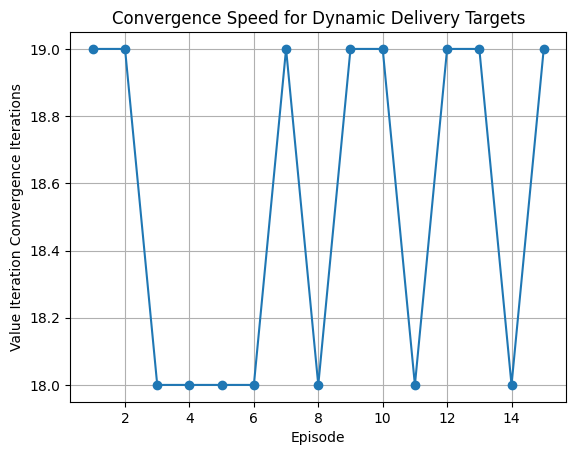

In [16]:
# Task 2: Dynamic Delivery Targets and Value Iteration Adaptation
import numpy as np
import mdptoolbox
import matplotlib.pyplot as plt
import random

rows, cols = 5, 5
num_states = rows * cols
shelves = [(1, 1), (2, 2), (3, 3)]
actions = ['up', 'down', 'left', 'right']
num_actions = len(actions)
movement = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}

def to_index(x, y):
    return x * cols + y

def set_dynamic_goal():
    possible = [(i, j) for i in range(rows) for j in range(cols) if (i, j) not in shelves]
    return random.choice(possible)

num_episodes = 15
convergence_iters = []
goal_positions = []
for episode in range(num_episodes):
    goal_state = set_dynamic_goal()
    goal_positions.append(goal_state)
    P = [np.zeros((num_states, num_states)) for _ in range(num_actions)]
    R = np.zeros((num_states, num_actions))
    for action_idx, action in enumerate(actions):
        dx, dy = movement[action]
        for x in range(rows):
            for y in range(cols):
                current_state = to_index(x, y)
                if (x, y) == goal_state:
                    P[action_idx][current_state, current_state] = 1
                    R[current_state, action_idx] = 10
                    continue
                outcomes = []
                new_x, new_y = x + dx, y + dy
                if (new_x, new_y) in shelves or not (0 <= new_x < rows and 0 <= new_y < cols):
                    new_state = current_state
                    reward = -5 if (new_x, new_y) in shelves else -1
                else:
                    new_state = to_index(new_x, new_y)
                    reward = -1
                outcomes.append((new_state, 0.9, reward))
                other_actions = [a for i, a in enumerate(actions) if i != action_idx]
                for mis_action in other_actions:
                    mx, my = movement[mis_action]
                    new_x, new_y = x + mx, y + my
                    if (new_x, new_y) in shelves or not (0 <= new_x < rows and 0 <= new_y < cols):
                        mis_state = current_state
                        mis_reward = -5 if (new_x, new_y) in shelves else -1
                    else:
                        mis_state = to_index(new_x, new_y)
                        mis_reward = -1
                    outcomes.append((mis_state, 0.1 / 3, mis_reward))
                for s_next, prob, rew in outcomes:
                    P[action_idx][current_state, s_next] += prob
                    R[current_state, action_idx] += prob * rew
    vi = mdptoolbox.mdp.ValueIteration(P, R, 0.9)
    vi.run()
    convergence_iters.append(vi.iter)
    print(f"Episode {episode+1}: Goal Position {goal_state}, Converged in {vi.iter} iterations")

plt.plot(range(1, num_episodes+1), convergence_iters, marker='o')
plt.xlabel('Episode')
plt.ylabel('Value Iteration Convergence Iterations')
plt.title('Convergence Speed for Dynamic Delivery Targets')
plt.grid(True)
plt.show()


## Task 3: Simulate Human Worker Zones with Time-Dependent Penalties

This cell simulates human workers walking through predefined zones at certain times by adding a high penalty for entering those zones. The policy computation is updated to factor in both time and position, ensuring the robot avoids human zones during restricted periods.

**Changes with respect to the original code:**
- Added a time dimension and defined human zones active at specific times.
- Added a high penalty for entering human zones during those times.
- Updated the policy to factor in both time and position.
- All other code remains unchanged.



📍 Optimal Policy Grid (Human Zones):
[['↓' '←' '→' '→' '↓']
 ['↓' '↓' '→' '→' '↓']
 ['↓' '←' '↓' '→' '↓']
 ['↓' '↓' '↓' '↓' '↓']
 ['→' '→' '↑' '←' '←']]


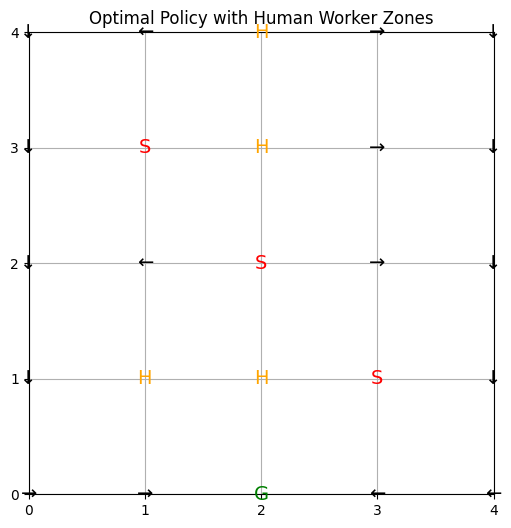

In [13]:
# Task 3: Simulate Human Worker Zones with Time-Dependent Penalties
import numpy as np
import mdptoolbox
import matplotlib.pyplot as plt
import random

rows, cols = 5, 5
num_states = rows * cols
shelves = [(1, 1), (2, 2), (3, 3)]
actions = ['up', 'down', 'left', 'right']
num_actions = len(actions)
movement = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}

def to_index(x, y):
    return x * cols + y

def set_dynamic_goal():
    possible = [(i, j) for i in range(rows) for j in range(cols) if (i, j) not in shelves]
    return random.choice(possible)

time_steps = 5
human_zones = {2: [(0, 2), (1, 2)], 4: [(3, 1), (3, 2)]}  # Zones active at specific times
high_penalty = -20

goal_state = set_dynamic_goal()
P = [np.zeros((num_states, num_states)) for _ in range(num_actions)]
R = np.zeros((num_states, num_actions))
for t in range(time_steps):
    for action_idx, action in enumerate(actions):
        dx, dy = movement[action]
        for x in range(rows):
            for y in range(cols):
                current_state = to_index(x, y)
                if (x, y) == goal_state:
                    P[action_idx][current_state, current_state] = 1
                    R[current_state, action_idx] = 10
                    continue
                # Check if human zone is active at this time
                if t in human_zones and (x, y) in human_zones[t]:
                    R[current_state, action_idx] = high_penalty
                outcomes = []
                new_x, new_y = x + dx, y + dy
                if (new_x, new_y) in shelves or not (0 <= new_x < rows and 0 <= new_y < cols):
                    new_state = current_state
                    reward = -5 if (new_x, new_y) in shelves else -1
                elif t in human_zones and (new_x, new_y) in human_zones[t]:
                    new_state = to_index(new_x, new_y)
                    reward = high_penalty
                else:
                    new_state = to_index(new_x, new_y)
                    reward = -1
                outcomes.append((new_state, 0.9, reward))
                other_actions = [a for i, a in enumerate(actions) if i != action_idx]
                for mis_action in other_actions:
                    mx, my = movement[mis_action]
                    new_x, new_y = x + mx, y + my
                    if (new_x, new_y) in shelves or not (0 <= new_x < rows and 0 <= new_y < cols):
                        mis_state = current_state
                        mis_reward = -5 if (new_x, new_y) in shelves else -1
                    elif t in human_zones and (new_x, new_y) in human_zones[t]:
                        mis_state = to_index(new_x, new_y)
                        mis_reward = high_penalty
                    else:
                        mis_state = to_index(new_x, new_y)
                        mis_reward = -1
                    outcomes.append((mis_state, 0.1 / 3, mis_reward))
                for s_next, prob, rew in outcomes:
                    P[action_idx][current_state, s_next] += prob / time_steps
                    R[current_state, action_idx] += (prob * rew) / time_steps
vi = mdptoolbox.mdp.ValueIteration(P, R, 0.9)
vi.run()
policy_grid = np.array(vi.policy).reshape((rows, cols))
action_symbols = ['↑', '↓', '←', '→']
policy_symbols = np.array([[action_symbols[a] for a in row] for row in policy_grid])
print("\n📍 Optimal Policy Grid (Human Zones):")
print(policy_symbols)
plt.figure(figsize=(6, 6))
for x in range(rows):
    for y in range(cols):
        idx = to_index(x, y)
        if (x, y) == goal_state:
            plt.text(y, rows - x - 1, 'G', ha='center', va='center', fontsize=14, color='green')
        elif (x, y) in shelves:
            plt.text(y, rows - x - 1, 'S', ha='center', va='center', fontsize=14, color='red')
        elif any((x, y) in zones for zones in human_zones.values()):
            plt.text(y, rows - x - 1, 'H', ha='center', va='center', fontsize=14, color='orange')
        else:
            plt.text(y, rows - x - 1, action_symbols[vi.policy[idx]], ha='center', va='center', fontsize=14)
plt.xticks(range(cols))
plt.yticks(range(rows))
plt.grid(True)
plt.title("Optimal Policy with Human Worker Zones")
plt.show()